In [85]:
import pandas as pd

In [86]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/kevin/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['std', 'bar', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Jeu de données, informations physico-chimiques de vins portugais et leur qualité notée par des humains

In [87]:
# load dataset
data = pd.read_csv("datasets/winequality-red+(7).csv", sep=";")

In [88]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [89]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [90]:
data['quality'].unique()

array([5, 6, 7, 4, 8, 3])

### extract data, X pour les indicateurs et Y pour la qualité


In [91]:
X = data[data.columns[:-1]].values
Y = data['quality'].values

In [92]:
print(X.shape, Y.shape)

(1599, 11) (1599,)


### Visualisation de la distribution des indicateurs


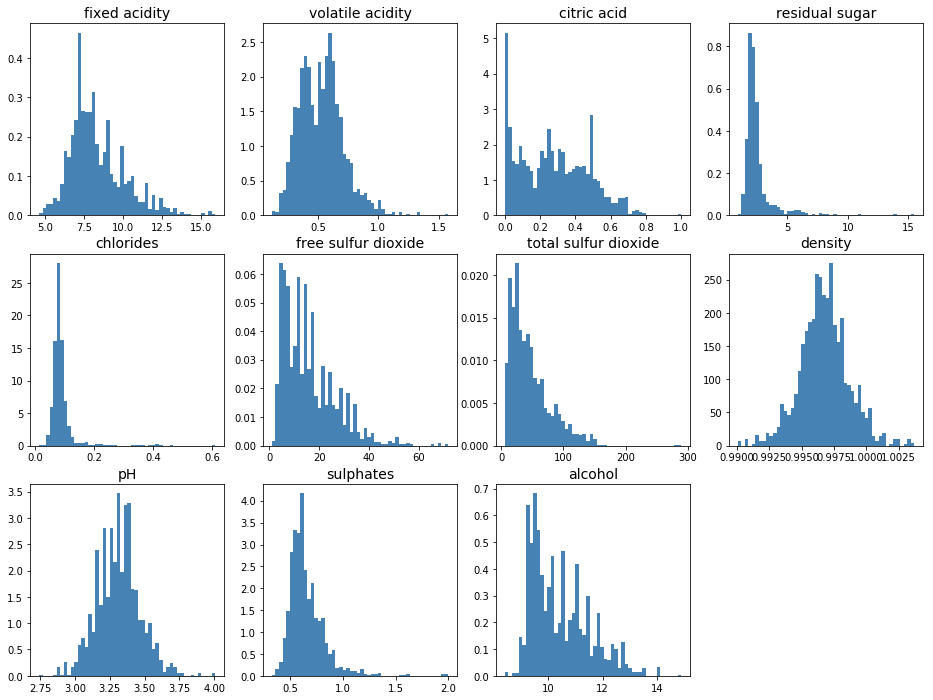

In [93]:
fig = plt.figure(figsize=(16,12))
for ind in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (ind+1))
    h = ax.hist(X[:,ind], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[ind], fontsize=14)

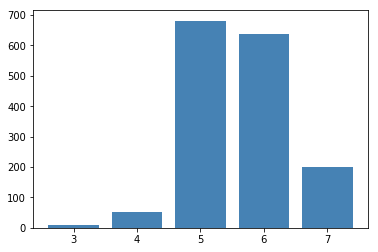

In [94]:
# etiquete distribution

absc = range(np.min(Y), np.max(Y))
bar = plt.bar(absc, [(Y == a).sum() for a in absc], color='steelblue')

In [95]:
# etique sup à 6 vin assez bon, sinon médiocre
y_class = np.where(Y < 6, 0, 1)

In [96]:
y_class

array([0, 0, 0, ..., 1, 0, 1])

In [97]:
y_class[y_class==1].shape

(855,)

In [98]:
y_class[y_class==0].shape

(744,)

## Split data into train and test

In [99]:
from sklearn.model_selection import  train_test_split

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y_class, test_size=0.30)

In [101]:
# standardisation des données
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
# apprendre ses paramètres sur le jeu d'entrainement
std.fit(X_train)

X_train = std.transform(X_train)
X_test = std.transform(X_test)

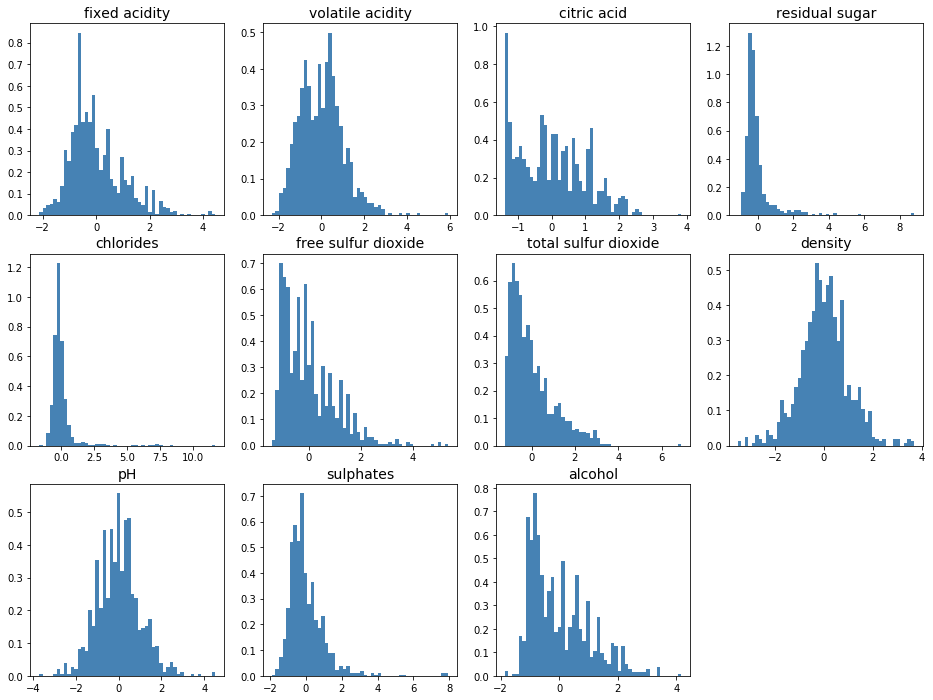

In [102]:
fig = plt.figure(figsize=(16,12))
for ind in range(X_train.shape[1]):
    ax = fig.add_subplot(3,4, (ind+1))
    h = ax.hist(X_train[:,ind], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[ind], fontsize=14)

## Sélection du meilleur modèle KNN ( choisir K ) : Validation croisée sur le jeu d'entrainement

In [103]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV #selection des meilleurs hyperparamètres

In [104]:
knn_clf = GridSearchCV(neighbors.KNeighborsClassifier(), 
                       {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}, # hyperparams à tester
                       cv=5, # nbre de folds pour le cross-validation
                       scoring='accuracy' # score à optimiser
                      )

In [105]:
# lancer le classifieur sur le jeu d'entrainement
knn_clf.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [106]:
# Fin de la recherche des hyperparams par validation croisée
# afficher les meilleur paramètres

knn_clf.best_params_

{'n_neighbors': 11}

In [107]:
best_neighbor = knn_clf.best_params_

In [108]:
# afficher les resultats pour chaque hyperparamètres
for mean, std, params in zip(knn_clf.cv_results_['mean_test_score'],
                             knn_clf.cv_results_['std_test_score'],
                             knn_clf.cv_results_['params']):
    print ("\t accuracy = %0.3f (+/-%0.3f) for %s" %(mean, std*2, params))

	 accuracy = 0.696 (+/-0.075) for {'n_neighbors': 3}
	 accuracy = 0.705 (+/-0.055) for {'n_neighbors': 5}
	 accuracy = 0.718 (+/-0.044) for {'n_neighbors': 7}
	 accuracy = 0.715 (+/-0.061) for {'n_neighbors': 9}
	 accuracy = 0.727 (+/-0.070) for {'n_neighbors': 11}
	 accuracy = 0.719 (+/-0.061) for {'n_neighbors': 13}
	 accuracy = 0.720 (+/-0.086) for {'n_neighbors': 15}


In [109]:
# GridSearch a automatiquement ré-entraîné le meilleur modèle sur l'intégralité du jeu d'entraînement
# evaluation du modèle sur le jeu de test

y_pred = knn_clf.predict(X_test)

In [110]:
# performance
from sklearn.metrics import accuracy_score

print('Performance du modèle: {:.3f}'.format(accuracy_score(Y_test, y_pred)))

Performance du modèle: 0.727


## Evaluation performance du modèle

In [111]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix, classification_report

print (confusion_matrix(Y_test, y_pred))

[[135  57]
 [ 74 214]]


In [112]:
print(classification_report(Y_test, y_pred))

             precision    recall  f1-score   support

          0       0.65      0.70      0.67       192
          1       0.79      0.74      0.77       288

avg / total       0.73      0.73      0.73       480



## Courbe ROC du model KNN : sensibilité = f(spécificité)

In [113]:
y_pred_prob = knn_clf.predict_proba(X_test)

In [114]:
y_pred_prob[0]

array([0.36363636, 0.63636364])

In [115]:
y_pred_prob = y_pred_prob[:,1]

In [116]:
from sklearn.metrics import roc_curve

In [117]:
[fpr, tpr, thr] = roc_curve(Y_test, y_pred_prob)

Text(0,0.5,'sensibilité')

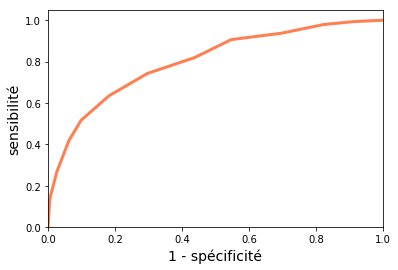

In [118]:
plt.plot(fpr, tpr, color='coral', lw=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - spécificité', fontsize=14)
plt.ylabel('sensibilité', fontsize=14)

### AUROC : Area Under ROC

In [119]:
from sklearn.metrics import auc

In [120]:
print("AUROC du modèle : {:.3f}".format(auc(fpr, tpr)
                                       ))

AUROC du modèle : 0.800


## Choix du seuil

In [121]:
# indice du premier seuil pour lequel
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95)) 

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1-fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))

Sensibilité : 0.98
Spécificité : 0.18
Seuil : 0.18


## Modèle de régression

In [126]:
X_train_rg, X_test_rg, Y_train_rg, Y_test_rg = train_test_split(X, Y, test_size=0.30)

In [127]:
std_rg = StandardScaler().fit(X_train_rg)
X_train_rg = std_rg.transform(X_train_rg)
X_test_rg= std_rg.transform(X_test_rg)

In [165]:
#knn_rgr = neighbors.KNeighborsRegressor(n_neighbors=11)
knn_rgr = GridSearchCV(neighbors.KNeighborsRegressor(), 
                       {'n_neighbors':[i for i in range(1,15,2)]}, # hyperparams à tester
                       cv=5, # nbre de folds pour le cross-validation
                       scoring='neg_mean_squared_error' # score à optimiser
                      )

In [166]:
knn_rgr.fit(X_train_rg, Y_train_rg)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [168]:
knn_rgr.best_params_

{'n_neighbors': 13}

In [169]:
# afficher les resultats pour chaque hyperparamètres
for mean, std, params in zip(knn_rgr.cv_results_['mean_test_score'],
                             knn_rgr.cv_results_['std_test_score'],
                             knn_rgr.cv_results_['params']):
    print ("\t accuracy = %0.3f (+/-%0.3f) for %s" %(mean, std*2, params))

	 accuracy = -0.636 (+/-0.055) for {'n_neighbors': 1}
	 accuracy = -0.506 (+/-0.097) for {'n_neighbors': 3}
	 accuracy = -0.475 (+/-0.080) for {'n_neighbors': 5}
	 accuracy = -0.461 (+/-0.105) for {'n_neighbors': 7}
	 accuracy = -0.454 (+/-0.103) for {'n_neighbors': 9}
	 accuracy = -0.454 (+/-0.117) for {'n_neighbors': 11}
	 accuracy = -0.451 (+/-0.113) for {'n_neighbors': 13}


In [170]:
y_pred_rg = knn_rgr.predict(X_test_rg)

In [171]:
from sklearn import metrics 

In [172]:
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(Y_test_rg, y_pred_rg) )))

RMSE : 0.67


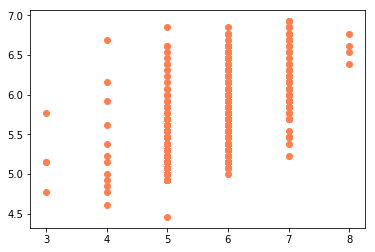

In [173]:
plt.scatter(Y_test_rg, y_pred_rg, color='coral')

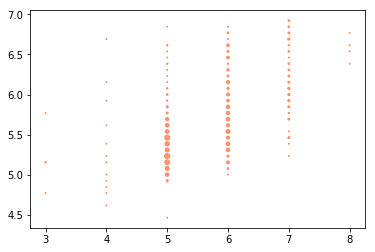

In [174]:
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
for (yt, yp) in zip(list(Y_test_rg), list(y_pred_rg)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1

keys = sizes.keys()
plt.scatter(
        [k[0] for k in keys], # vraie valeur (abscisse)
        [k[1] for k in keys], # valeur predite (ordonnee)
        s=[sizes[k] for k in keys], # taille du marqueur
        color='coral', alpha =0.8)


## Approche NAÏVE

In [175]:
y_pred_random = np.random.randint(np.min(Y), np.max(Y), Y_test_rg.shape)

In [176]:
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(Y_test_rg, y_pred_random))))

RMSE : 1.74


## Modèle précent meilleur que le modèle aléatoire
Cependant, beaucoup de nos vins ont une note de 5 ou de 6, et beaucoup de nos prédictions sont autour de cette valeur. Comparons maintenant notre modèle à un modèle aléatoire qui retourne systématiquement la valeur moyenne des étiquettes du jeu de données d'entraînement.

In [177]:
from sklearn import dummy
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_train_rg, Y_train_rg)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_rg)

# Evaluate
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(Y_test_rg, y_pred_dum)) ))


RMSE : 0.81
